<a href="https://colab.research.google.com/github/Baskar-t/AWS-CDK/blob/main/Gesture_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [ ]:
!pip install tf-keras

In [ ]:
!unzip /content/drive/MyDrive/Project_data.zip -d /content/drive/MyDrive/Project_data

In [28]:
import numpy as np
import os
from skimage import io, transform
import datetime
import os
from PIL import Image, ImageFilter, ImageEnhance
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

We set the random seed so that the results don't vary drastically.

In [29]:
import os
os.environ['PYTHONHASHSEED']="30"
np.random.seed(30)
import random as rn
rn.seed(30)
import tensorflow as tf
tf.random.set_seed(30)


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [30]:
# train and validatiaon data creator with ablation
# when ablation is 10, then 10 folders for each label will be selected.
def get_data(path, ablation=None):
    train_doc = np.random.permutation(open(path+'train.csv').readlines())
    val_doc = np.random.permutation(open(path+'val.csv').readlines())
    counts = np.zeros(5) # count for loading folders for 5 classes
    train_data = []
    val_data = []
    # when ablation is None pass full training and val data
    if ablation is not None:
        # iterating train doc
        for doc in train_doc:
            lable = int(doc.strip().split(';')[2])
            if counts[lable] < ablation:
                train_data.append(doc)
                counts[lable] += 1
        counts = np.zeros(5)
        # iterating val doc
        for doc in val_doc:
            lable = int(doc.strip().split(';')[2])
            if counts[lable] < ablation:
                val_data.append(doc)
                counts[lable] += 1
    else:
        train_data, val_data = train_doc, val_doc
    return train_data, val_data

In [31]:
train_doc, val_doc = get_data('/content/drive/MyDrive/Project_data/Project_data/', ablation=None)
batch_size = 32 # experiment with the batch size
enable_augmentation = False # augmentation of Data
# sequence ids
# selecting alternate frames from 7 to 26.
seq_idx = range(7,26,2)
# image dimensions
dim_x, dim_y = 120, 120

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [32]:
# generator with augmentation for train data
def generator(source_path, folder_list, batch_size, is_train = False, augmention = False, debug=False):
    # print('\nSource path = ', source_path, '; batch size =', batch_size)
    img_idx = seq_idx #create a list of image numbers you want to use for a particular video
    x = len(img_idx)
    y, z = dim_x, dim_y
    while True:
        # doubling the data for augmentation
        if is_train and augmention:
            t = np.concatenate((np.random.permutation(folder_list), np.random.permutation(folder_list)))
        else:
            t = np.random.permutation(folder_list)

        if (len(t)%batch_size) == 0:
            num_batches = int(len(t)/batch_size)
        else:
            num_batches = len(t)//batch_size + 1

        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                if debug:
                    plt.figure(figsize=(20,5))
                #handling remaining datapoints
                folder_idx = folder + (batch*batch_size)
                if folder_idx >= len(t):
                    break
                folder_str = t[folder_idx]
                imgs = os.listdir(source_path+'/'+ folder_str.split(';')[0]) # read all the images in the folder
                # randomly enabling augmentation and augmentation type
                aug_type = None
                if is_train and augmention and rn.randint(0,1) == 1:
                    aug_type = rn.randint(0, 4) #randomly selecting augmentation type
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ folder_str.strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    # plotting original images for debugging purpose only
                    if debug:
                        plt.subplot(2, x, idx+1)
                        plt.imshow(image.astype('uint8'))

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # making the rectangle images into square by cropping sides
                    # so the aspect ration can be mantained while resizing.
                    if image.shape[1] > image.shape[0]:
                        diff_px = image.shape[1] - image.shape[0]
                        crop_start = diff_px//2
                        crop_end = crop_start + image.shape[0]
                        image = image[:, crop_start:crop_end]
                    elif image.shape[0] > image.shape[1]:
                        diff_px = image.shape[0] - image.shape[1]
                        crop_start = diff_px//2
                        crop_end = crop_start + image.shape[1]
                        image = image[:, crop_start:crop_end]


                    resized_im = transform.resize(image, (y,z))

                    if aug_type is not None:
                        if aug_type == 0: # edge Enhancement
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.EDGE_ENHANCE))
                        elif aug_type == 1: # adding gaussian blur
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.GaussianBlur(1)))
                        elif aug_type == 2: # enchancing image detailing
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.DETAIL))
                        elif aug_type == 3: # sharpening image
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.SHARPEN))
                        elif aug_type == 4: # Brightness enhancement
                            resized_im = np.array(ImageEnhance.Brightness((Image.fromarray(resized_im, 'RGB'))).enhance(1.5))
                    # plotting rezised images for debugging purpose only
                    if debug:
                        plt.subplot(2, x, idx+x+1)
                        plt.imshow(resized_im)

                    batch_data[folder,idx,:,:,0] = resized_im[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = resized_im[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = resized_im[:,:,2]/255 #normalise and feed in the image

                batch_labels[folder, int(folder_str.strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [41]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/Project_data/Project_data/train' #'/notebooks/storage/Final_data/Collated_training/train'
val_path =  '/content/drive/MyDrive/Project_data/Project_data/val' #'/notebooks/storage/Final_data/Collated_training/val'

#multiply number train seq by 2 when using augmentation
multiplier = 1
if enable_augmentation:
    multiplier = 2
num_train_sequences = len(train_doc)*multiplier
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

num_epochs = 5 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 5


In [ ]:
# testing generative
test_gen = generator(train_path, train_doc, 1, is_train = True, augmention = True, debug = True)
d = next(test_gen)[1]

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [35]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Bidirectional, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, GlobalAveragePooling3D, ConvLSTM2D
from keras.layers import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from tensorflow.keras.layers import InputSpec

#input shape for the st layer
input_shape = (len(seq_idx), dim_x, dim_y, 3)
np.random.seed(30)

# Time Distributed LSTM Conv2D model

In [36]:
model = Sequential()
model.add(TimeDistributed(
    Conv2D(8, (3,3), activation='relu'), input_shape=input_shape)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Conv2D(16, (3,3), activation='relu'))
)
model.add(BatchNormalization())
model.add(
    ConvLSTM2D(8, kernel_size = 3, return_sequences=False)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Dense(64, activation='relu'))
)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [37]:
optimiser = optimizers.Adam(lr=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDi  (None, 10, 118, 118, 8)   224       
 stributed)                                                      
                                                                 
 batch_normalization_4 (Bat  (None, 10, 118, 118, 8)   32        
 chNormalization)                                                
                                                                 
 time_distributed_4 (TimeDi  (None, 10, 116, 116, 16   1168      
 stributed)                  )                                   
                                                                 
 batch_normalization_5 (Bat  (None, 10, 116, 116, 16   64        
 chNormalization)            )                                   
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 114, 114, 8)      

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [38]:
train_generator = generator(train_path, train_doc, batch_size, is_train = True, augmention = enable_augmentation)
val_generator = generator(val_path, val_doc, batch_size)

In [39]:
model_name = 'model_LSTM_CONV2D' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [22]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [42]:
Model_LSTM_Conv2D = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                        callbacks=callbacks_list, validation_data=val_generator,
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/5
21/21 [==============================] - ETA: 0s - loss: 1.4714 - categorical_accuracy: 0.3348
Epoch 1: saving model to model_LSTM_CONV2D_2024-04-0919_39_48.994215/model-00001-1.47145-0.33482-1.25197-0.16406.h5
21/21 [==============================] - 450s 22s/step - loss: 1.4714 - categorical_accuracy: 0.3348 - val_loss: 1.2520 - val_categorical_accuracy: 0.1641 - lr: 0.0010
Epoch 2/5
21/21 [==============================] - ETA: 0s - loss: 1.2508 - categorical_accuracy: 0.5000
Epoch 2: saving model to model_LSTM_CONV2D_2024-04-0919_39_48.994215/model-00002-1.25084-0.50000-1.23312-0.16406.h5
21/21 [==============================] - 107s 5s/step - loss: 1.2508 - categorical_accuracy: 0.5000 - val_loss: 1.2331 - val_categorical_accuracy: 0.1641 - lr: 0.0010
Epoch 3/5
21/21 [==============================] - ETA: 0s - loss: 1.1560 - categorical_accuracy: 0.5417
Epoch 3: saving model to model_LSTM_CONV2D_2024-04-0919_39_48.994215/model-00003-1.15602-0.54167-1.21436-0.26562.h5
21

In [43]:
Model_LSTM_Conv2D = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                        callbacks=callbacks_list, validation_data=val_generator,
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/5
21/21 [==============================] - ETA: 0s - loss: 0.9577 - categorical_accuracy: 0.5878
Epoch 1: saving model to model_LSTM_CONV2D_2024-04-0919_39_48.994215/model-00001-0.95767-0.58780-1.24837-0.20312.h5
21/21 [==============================] - 99s 5s/step - loss: 0.9577 - categorical_accuracy: 0.5878 - val_loss: 1.2484 - val_categorical_accuracy: 0.2031 - lr: 0.0010
Epoch 2/5
21/21 [==============================] - ETA: 0s - loss: 0.8638 - categorical_accuracy: 0.6682
Epoch 2: saving model to model_LSTM_CONV2D_2024-04-0919_39_48.994215/model-00002-0.86380-0.66815-1.26425-0.25000.h5
21/21 [==============================] - 95s 5s/step - loss: 0.8638 - categorical_accuracy: 0.6682 - val_loss: 1.2643 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/5
21/21 [==============================] - ETA: 0s - loss: 0.8218 - categorical_accuracy: 0.6667
Epoch 3: saving model to model_LSTM_CONV2D_2024-04-0919_39_48.994215/model-00003-0.82179-0.66667-1.39898-0.16406.h5
21/21

In [44]:
Model_LSTM_Conv2D = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1,
                        callbacks=callbacks_list, validation_data=val_generator,
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 0.7108 - categorical_accuracy: 0.7083
Epoch 1: saving model to model_LSTM_CONV2D_2024-04-0919_39_48.994215/model-00001-0.71075-0.70833-1.55013-0.14844.h5
21/21 [==============================] - 104s 5s/step - loss: 0.7108 - categorical_accuracy: 0.7083 - val_loss: 1.5501 - val_categorical_accuracy: 0.1484 - lr: 0.0010
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 0.7183 - categorical_accuracy: 0.7158
Epoch 2: saving model to model_LSTM_CONV2D_2024-04-0919_39_48.994215/model-00002-0.71827-0.71577-1.49012-0.23438.h5
21/21 [==============================] - 110s 5s/step - loss: 0.7183 - categorical_accuracy: 0.7158 - val_loss: 1.4901 - val_categorical_accuracy: 0.2344 - lr: 0.0010
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 0.6549 - categorical_accuracy: 0.7455
Epoch 3: saving model to model_LSTM_CONV2D_2024-04-0919_39_48.994215/model-00003-0.65492-0.74554-1.75939-0.17188.h5


In [45]:
Model_LSTM_Conv2D = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1,
                        callbacks=callbacks_list, validation_data=val_generator,
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 0.5133 - categorical_accuracy: 0.7783
Epoch 1: saving model to model_LSTM_CONV2D_2024-04-0919_39_48.994215/model-00001-0.51328-0.77827-2.12138-0.21094.h5
21/21 [==============================] - 100s 5s/step - loss: 0.5133 - categorical_accuracy: 0.7783 - val_loss: 2.1214 - val_categorical_accuracy: 0.2109 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 0.5518 - categorical_accuracy: 0.7619
Epoch 2: saving model to model_LSTM_CONV2D_2024-04-0919_39_48.994215/model-00002-0.55180-0.76190-2.32358-0.21094.h5
21/21 [==============================] - 98s 5s/step - loss: 0.5518 - categorical_accuracy: 0.7619 - val_loss: 2.3236 - val_categorical_accuracy: 0.2109 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 0.5298 - categorical_accuracy: 0.7619
Epoch 3: saving model to model_LSTM_CONV2D_2024-04-0919_39_48.994215/model-00003-0.52982-0.76190-1.81737-0.25000.h5
2

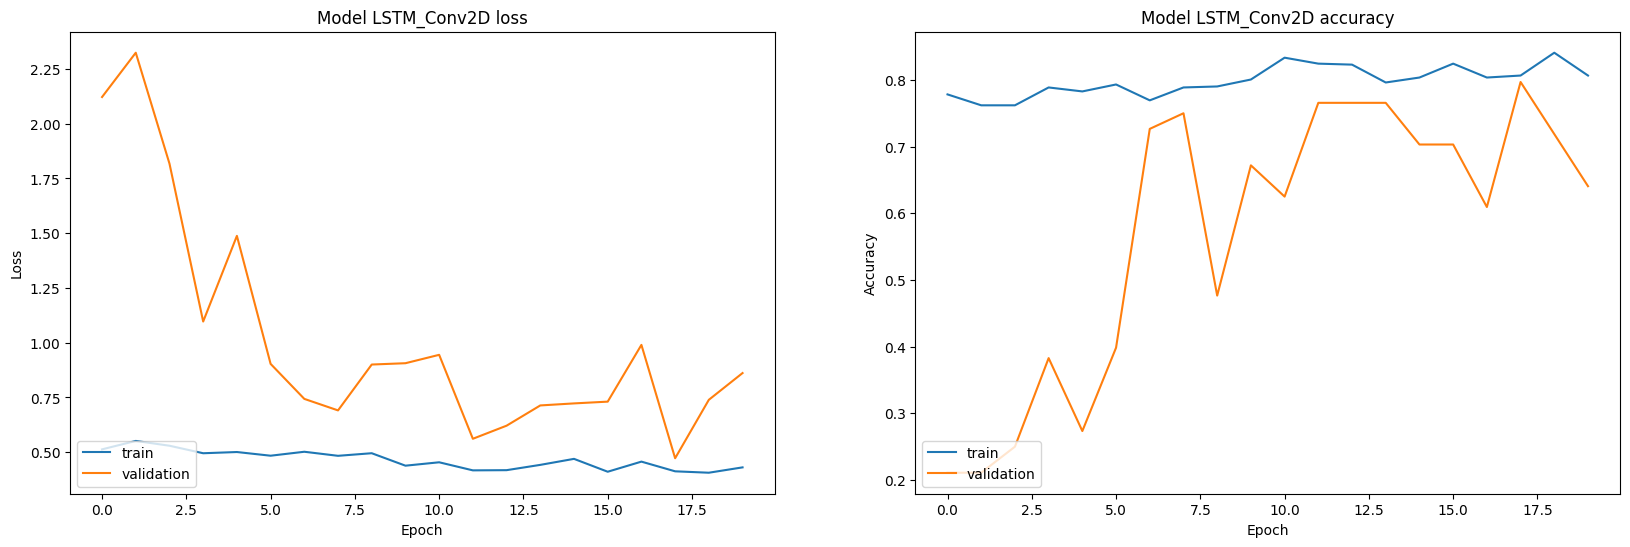

In [47]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(Model_LSTM_Conv2D.history['loss'])
ax1 = plt.plot(Model_LSTM_Conv2D.history['val_loss'])
plt.title('Model LSTM_Conv2D loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(Model_LSTM_Conv2D.history['categorical_accuracy'])
ax2 = plt.plot(Model_LSTM_Conv2D.history['val_categorical_accuracy'])
plt.title('Model LSTM_Conv2D accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='lower left')
plt.show()

# CONV3D Model without Batch Normalization and Dropout

In [48]:
# Conv3D without batch normalization and dropout
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [49]:
optimiser = optimizers.Adam(lr=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 8, 118, 118, 32)   2624      
                                                                 
 conv3d_1 (Conv3D)           (None, 6, 116, 116, 64)   55360     
                                                                 
 max_pooling3d (MaxPooling3  (None, 3, 58, 58, 64)     0         
 D)                                                              
                                                                 
 conv3d_2 (Conv3D)           (None, 1, 56, 56, 128)    221312    
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 1, 28, 28, 128)    0         
 g3D)                                                            
                                                                 
 conv3d_3 (Conv3D)           (None, 1, 26, 26, 256)   

In [50]:
model_name = 'model_CONV3D_no_Batch_Norm' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

In [51]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [52]:
model_CONV3D_no_Batch_Norm = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=5, verbose=1,
                        callbacks=callbacks_list, validation_data=val_generator,
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/5
21/21 [==============================] - ETA: 0s - loss: 1.6999 - categorical_accuracy: 0.1860
Epoch 1: saving model to model_CONV3D_no_Batch_Norm_2024-04-0919_42_42.460983/model-00001-1.69991-0.18601-1.25532-0.16406.h5
21/21 [==============================] - 102s 4s/step - loss: 1.6999 - categorical_accuracy: 0.1860 - val_loss: 1.2553 - val_categorical_accuracy: 0.1641 - lr: 0.0010
Epoch 2/5
21/21 [==============================] - ETA: 0s - loss: 1.5859 - categorical_accuracy: 0.2098
Epoch 2: saving model to model_CONV3D_no_Batch_Norm_2024-04-0919_42_42.460983/model-00002-1.58591-0.20982-1.25323-0.37500.h5
21/21 [==============================] - 89s 4s/step - loss: 1.5859 - categorical_accuracy: 0.2098 - val_loss: 1.2532 - val_categorical_accuracy: 0.3750 - lr: 0.0010
Epoch 3/5
21/21 [==============================] - ETA: 0s - loss: 1.5628 - categorical_accuracy: 0.2798
Epoch 3: saving model to model_CONV3D_no_Batch_Norm_2024-04-0919_42_42.460983/model-00003-1.56275-0.27

In [53]:
model_CONV3D_no_Batch_Norm = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1,
                        callbacks=callbacks_list, validation_data=val_generator,
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 1.2798 - categorical_accuracy: 0.4018
Epoch 1: saving model to model_CONV3D_no_Batch_Norm_2024-04-0919_42_42.460983/model-00001-1.27982-0.40179-0.96202-0.35938.h5
21/21 [==============================] - 92s 5s/step - loss: 1.2798 - categorical_accuracy: 0.4018 - val_loss: 0.9620 - val_categorical_accuracy: 0.3594 - lr: 0.0010
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 1.2742 - categorical_accuracy: 0.4301
Epoch 2: saving model to model_CONV3D_no_Batch_Norm_2024-04-0919_42_42.460983/model-00002-1.27420-0.43006-1.04452-0.32031.h5
21/21 [==============================] - 91s 5s/step - loss: 1.2742 - categorical_accuracy: 0.4301 - val_loss: 1.0445 - val_categorical_accuracy: 0.3203 - lr: 0.0010
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 1.1896 - categorical_accuracy: 0.4435
Epoch 3: saving model to model_CONV3D_no_Batch_Norm_2024-04-0919_42_42.460983/model-00003-1.18961-0.

# CONV3D Model with Batch Normalization and Dropout

In [54]:
#Conv 3D with batch normalization and Dropout
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(GlobalAveragePooling3D())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

In [55]:
optimiser = optimizers.Adam(lr=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 8, 118, 118, 32)   2624      
                                                                 
 conv3d_7 (Conv3D)           (None, 6, 116, 116, 64)   55360     
                                                                 
 max_pooling3d_4 (MaxPoolin  (None, 3, 58, 58, 64)     0         
 g3D)                                                            
                                                                 
 batch_normalization_8 (Bat  (None, 3, 58, 58, 64)     256       
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 3, 58, 58, 64)     0         
                                                                 
 conv3d_8 (Conv3D)           (None, 1, 56, 56, 128)   

In [56]:
model_name = 'model_CONV3D_Batch_Norm' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

In [57]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [58]:
model_CONV3D_Batch_Norm = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=15, verbose=1,
                        callbacks=callbacks_list, validation_data=val_generator,
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/15
21/21 [==============================] - ETA: 0s - loss: 1.5666 - categorical_accuracy: 0.3958
Epoch 1: saving model to model_CONV3D_Batch_Norm_2024-04-0919_42_42.460983/model-00001-1.56661-0.39583-1.39472-0.11719.h5
21/21 [==============================] - 98s 5s/step - loss: 1.5666 - categorical_accuracy: 0.3958 - val_loss: 1.3947 - val_categorical_accuracy: 0.1172 - lr: 0.0010
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 1.1266 - categorical_accuracy: 0.5015
Epoch 2: saving model to model_CONV3D_Batch_Norm_2024-04-0919_42_42.460983/model-00002-1.12662-0.50149-1.42409-0.17969.h5
21/21 [==============================] - 90s 4s/step - loss: 1.1266 - categorical_accuracy: 0.5015 - val_loss: 1.4241 - val_categorical_accuracy: 0.1797 - lr: 0.0010
Epoch 3/15
21/21 [==============================] - ETA: 0s - loss: 0.9909 - categorical_accuracy: 0.5670
Epoch 3: saving model to model_CONV3D_Batch_Norm_2024-04-0919_42_42.460983/model-00003-0.99093-0.56696-1.3